In [1]:
setwd('/import/hd/sc')

In [2]:
fib = readRDS('./scRNA.fibro.rds')

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)



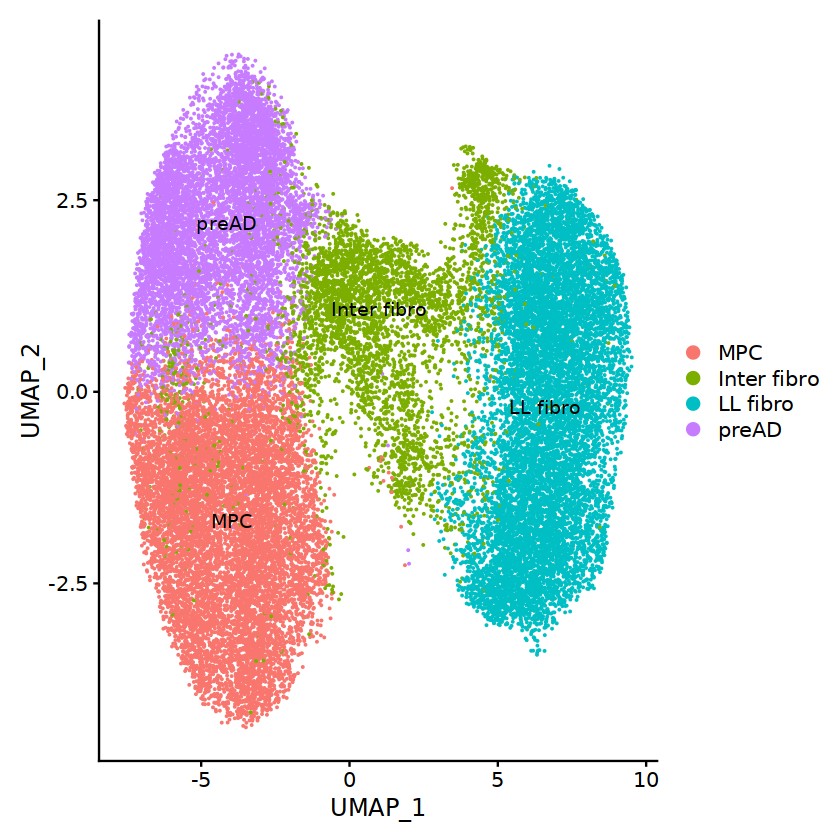

In [22]:
DimPlot(fib,label = T)

In [24]:
library(ggplot2)

Warning message:
"package 'ggplot2' was built under R version 4.2.3"


In [25]:
ggsave('../fib.sub.pdf',width = 6,height = 5)

In [27]:
options(repr.plot.width = 9)

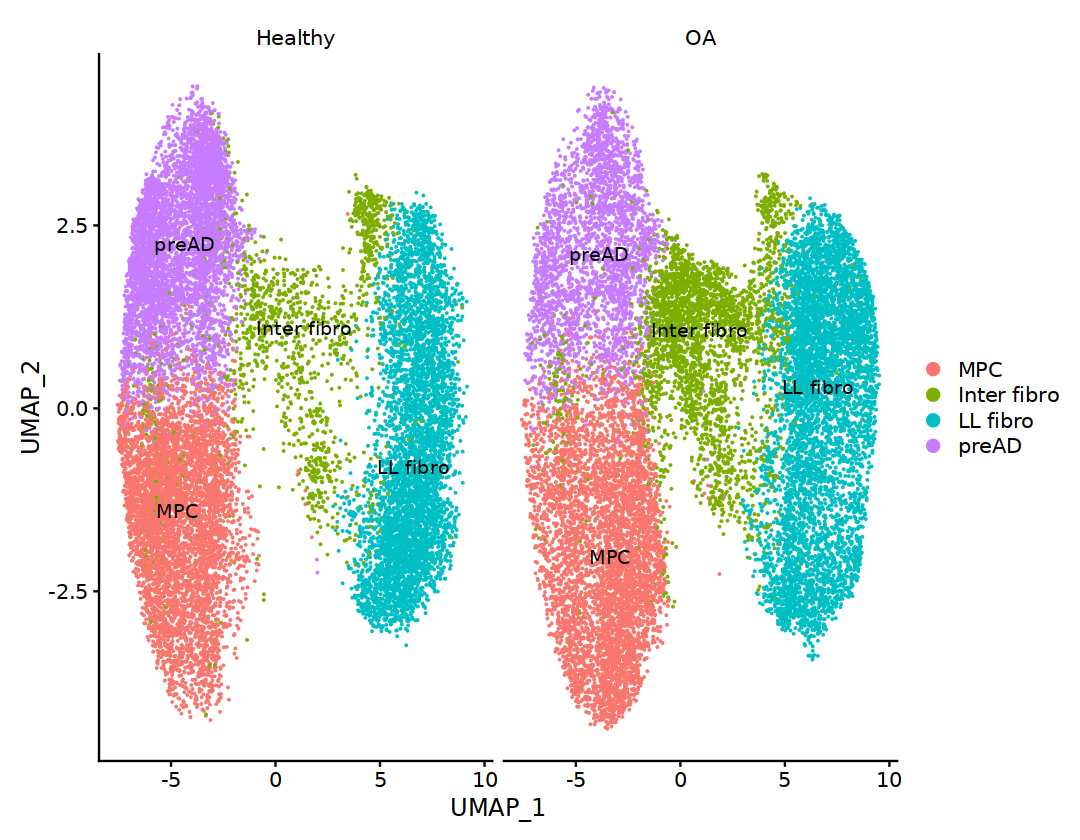

In [28]:
DimPlot(fib,label = T,split.by = 'group')

In [29]:
ggsave('../fib.sub.split.pdf',width = 9,height = 5)

In [3]:
library(Seurat)

Warning message:
"package 'Seurat' was built under R version 4.2.3"
Attaching SeuratObject



In [4]:
Idents(fib) = 'celltype'

In [5]:
unique(fib$celltype)

[1] "MPC"         "Inter fibro" "LL fibro"    "preAD"

In [6]:
immune.combined = fib

In [7]:
DefaultAssay(immune.combined) = 'RNA'
sce.markers <- FindAllMarkers(object = immune.combined, only.pos = TRUE, 
                              min.pct = 0.25, 
                              thresh.use = 0.25)

Calculating cluster MPC

Calculating cluster Inter fibro

Calculating cluster LL fibro

Calculating cluster preAD



In [8]:
library(dplyr)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [9]:
# 不同seurat版本的 avg_logFC 不一样 
top5 <- sce.markers %>% group_by(cluster) %>% top_n(10, avg_log2FC)

In [10]:

gene_cell_exp <- AverageExpression(immune.combined,
                                   features = unique(top5$gene),
                                   group.by = 'celltype',
                                   slot = 'data') 
gene_cell_exp <- as.data.frame(gene_cell_exp$RNA)

In [11]:
gene_cell_exp = gene_cell_exp[,c('MPC','Inter fibro','LL fibro','preAD')]

In [12]:
colnames(gene_cell_exp)

[1] "MPC"         "Inter fibro" "LL fibro"    "preAD"

In [13]:
library(ComplexHeatmap)
#顶部细胞类型注释
df <- data.frame(colnames(gene_cell_exp))
colnames(df) <- 'class'

Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




In [14]:
df$class

[1] "MPC"         "Inter fibro" "LL fibro"    "preAD"

In [15]:
df$class = factor(df$class,levels =  c('MPC','Inter fibro','LL fibro','preAD'))

In [16]:
top_anno = HeatmapAnnotation(df = df,#细胞名/cluster
                             border = T,
                             show_annotation_name = F,
                             gp = gpar(col = 'black'),
                             col = list(class = c( "MPC"="#067756",'Inter fibro'="#2F528F", 'LL fibro'="#F6F5B4",  
                                                  "preAD"="#E3AD68")))#颜色设置

In [17]:
#数据标准化缩放一下
marker_exp <- t(scale(t(gene_cell_exp),scale = T,center = T))

In [18]:
pdf('../figure2/fib.heatmap.pdf',height = 9,width = 6)

In [19]:
Heatmap(marker_exp,
        cluster_rows = F,
        cluster_columns = F,
        show_column_names = F,
        show_row_names = T,
        column_title = NULL,
        heatmap_legend_param = list(
          title=' '),
        col = colorRampPalette(c("#0D72C3","white","#E35B10"))(100),
        border = 'black',
        rect_gp = gpar(col = "black", lwd = 1),
        row_names_gp = gpar(fontsize = 13),
        column_names_gp = gpar(fontsize = 13),
        top_annotation = top_anno)
dev.off()

png 
  2

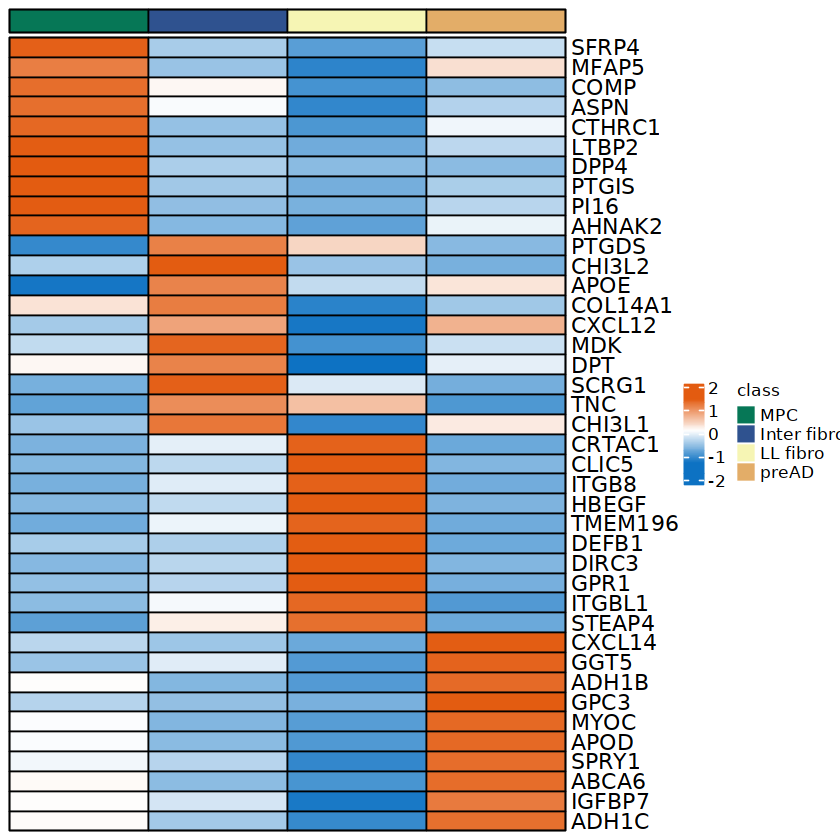

In [20]:
Heatmap(marker_exp,
        cluster_rows = F,
        cluster_columns = F,
        show_column_names = F,
        show_row_names = T,
        column_title = NULL,
        heatmap_legend_param = list(
          title=' '),
        col = colorRampPalette(c("#0D72C3","white","#E35B10"))(100),
        border = 'black',
        rect_gp = gpar(col = "black", lwd = 1),
        row_names_gp = gpar(fontsize = 13),
        column_names_gp = gpar(fontsize = 13),
        top_annotation = top_anno)

In [31]:
#kegg

In [1]:
library(GSVA)
library(tidyverse)
library(org.Hs.eg.db)

scRNA= immune.combined

Idents(scRNA) <- "celltype" 
expr <- AverageExpression(scRNA, assays = "RNA", slot = "data")[[1]]
expr <- expr[rowSums(expr)>0,]  #过滤细胞表达量全为零的基因
expr <- as.matrix(expr)

library(msigdbr)
msigdbr_species() #列出有的物种

#选择基因集合
human_KEGG = msigdbr(species = "Homo sapiens", #物种
                      category = "C2",
                     subcategory = "KEGG") %>% 
  dplyr::select(gs_name,gene_symbol)#这里可以选择gene symbol或者ID
human_KEGG_Set = human_KEGG %>% split(x = .$gene_symbol, f = .$gs_name)

library(GSVA)
gsva.kegg <- gsva(expr, gset.idx.list = human_KEGG_Set, 
             kcdf="Gaussian",
             method = "gsva",
             parallel.sz=1)
head(gsva.kegg)

a = c()
ds = as.data.frame(gsva.kegg) 
for (i in 1:dim(ds)[2] ){
    path = ds[ order (-ds[,i]),] %>%  head(8) %>%  rownames()
    a = unique(c(a,path))
 }
gsva.kegg = gsva.kegg[a,]
options(repr.plot.width = 9,repr.plot.height =  8)
rownames(gsva.kegg) = gsub('KEGG_','',rownames(gsva.kegg))
pdf('../figure2/enrichheatmap.kegg.fib.pdf',height = 7,width = 7)

Warning message:
"package 'GSVA' was built under R version 4.2.3"
Warning message:
"package 'ggplot2' was built under R version 4.2.3"
Warning message:
"package 'tibble' was built under R version 4.2.3"
Warning message:
"package 'tidyr' was built under R version 4.2.3"
Warning message:
"package 'readr' was built under R version 4.2.3"
Warning message:
"package 'purrr' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.3"
Warning message:
"package 'forcats' was built under R version 4.2.3"
Warning message:
"package 'lubridate' was built under R version 4.2.3"
Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"
-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts --------

ERROR: Error in eval(expr, envir, enclos): object 'immune.combined' not found


In [ ]:
library(pheatmap)
pheatmap(as.matrix(gsva.kegg), scale = "row",angle_col = "45",cluster_cols  = FALSE,cluster_rows = FALSE,
        
        show_column_names = F,
        show_row_names = T,
         color = colorRampPalette(c("navy", "white", "firebrick3"))(50))
dev.off()

### go富集分析

In [ ]:
library(msigdbr)
msigdbr_species() #列出有的物种

#选择基因集合
human_KEGG = msigdbr(species = "Homo sapiens", #物种
                      category = "C5",
                     subcategory = "BP") %>% 
  dplyr::select(gs_name,gene_symbol)#这里可以选择gene symbol或者ID
human_KEGG_Set = human_KEGG %>% split(x = .$gene_symbol, f = .$gs_name)

library(GSVA)
gsva.kegg <- gsva(expr, gset.idx.list = human_KEGG_Set, 
             kcdf="Gaussian",
             method = "gsva",
             parallel.sz=1)


tail(gsva.kegg)

a = c()
ds = as.data.frame(gsva.kegg) 
for (i in 1:dim(ds)[2] ){
    path = ds[ order (-ds[,i]),] %>%  head(8) %>%  rownames()
    a = unique(c(a,path))
 }
gsva.kegg = gsva.kegg[a,]


rownames(gsva.kegg) = gsub('GOBP_','',rownames(gsva.kegg))
pdf('../figure2/enrichheatmap.go.fib.pdf',height = 7,width = 12)

In [ ]:
options(repr.plot.width = 12,repr.plot.height =  7)

In [ ]:
library(pheatmap)
pheatmap(as.matrix(gsva.kegg), scale = "row",angle_col = "45",cluster_cols  = FALSE,cluster_rows = FALSE,
        
        show_column_names = F,
        show_row_names = T,
         color = colorRampPalette(c("navy", "white", "firebrick3"))(50))
dev.off()